In [1]:
import tensorflow as tf

print(tf.__version__)

2.12.0


Начнем с простой квадратичной зависимости:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

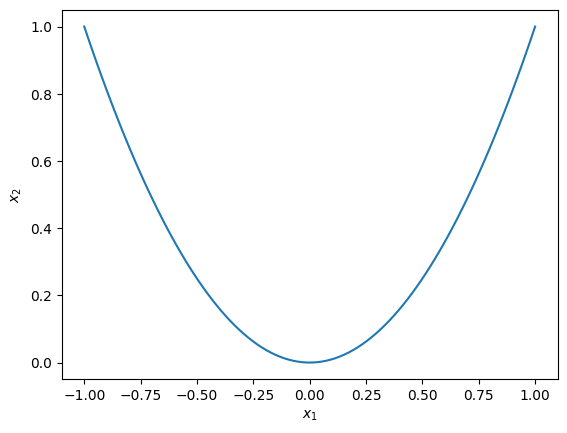

In [3]:
def real_f(x):
    return x * x

plt.plot(np.linspace(-1, 1, 100), real_f(np.linspace(-1, 1, 100)))
plt.ylabel("$x_2$")
plt.xlabel("$x_1$");

Сэмплировать из реального распределения можно следующим образом: сначала сэмплируем $x_1$, затем возводим его в квадрат и получаем $x_2$.

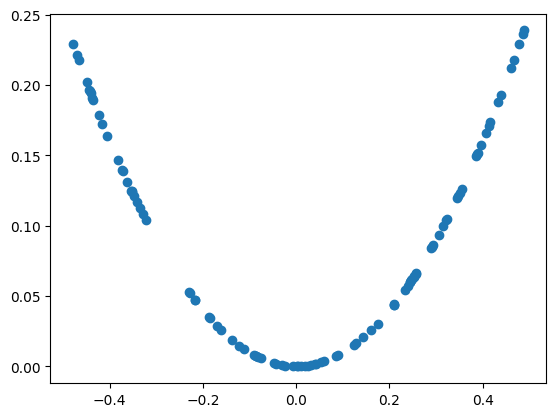

In [4]:
def generate_real_samples(n=100):
    """
    Функция сэмплирует данные из реального распределения.
    """
    x = np.random.rand(n) - .5
    y = real_f(x)
    return np.vstack((x, y)).T

real_data = generate_real_samples(n=100)
plt.scatter(real_data[:, 0], real_data[:, 1])

# Дискриминатор

А сейчас мы определим дискриминатор. Т.е. ту часть GAN, которая должна уметь отличать реальные сэмплы от нереальных. Для начала мы
обучим его отличать реальные данные от случайно сгенерированных, и лишь потом мы усложним ему задачу добавим "умного" соперника.
На вход она должна принимать объект (в нашем случае это точка с двумя координатами), а возвращать логит того, что жто точка из реального
распределения.

In [5]:
def build_discriminator(n_inputs=2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(10, activation='relu', input_dim=n_inputs))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

disctiminator = build_discriminator()
disctiminator.summary()

Metal device set to: Apple M2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


Для обучения дискриминатора мы должны также уметь генерировать фейковые данные. Позже это будет делать генератор (еще одна сеть), но пока
нам хватит генератора случайных чисел.

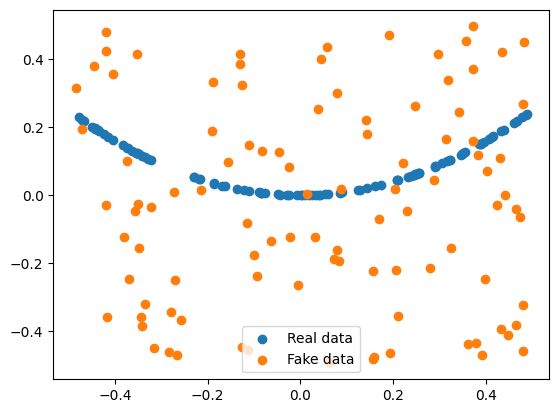

In [6]:
def generate_fake_samples(n):
    x = np.random.rand(n) - .5
    y = np.random.rand(n) - .5
    return np.vstack((x, y)).T

fake_data = generate_fake_samples(100)
# отличить такие данные очень просто:
plt.scatter(real_data[:, 0], real_data[:, 1], label="Real data")
plt.scatter(fake_data[:, 0], fake_data[:, 1], label="Fake data")
plt.legend(loc="best")

# Лосс дискриминатора
При обучении дискриминатора мы будем подавать ему половину батча из реальных сэмплов, а половину из фейковых. Его задача предсказать
"класс 1" - реальные данные для реальной половины и "класс 0" - фейковые для нереальных. Теперь запишем это с помощью функции:

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_pred_real_data, disc_pred_fake_data):
    """
    disc_pred_real_data -- логиты, предсказанные дискриминатором для реальных данных
    disc_pred_fake_data -- логиты, предсказанные дискриминатором для фэйковых данных
    """
    real_labels = tf.ones_like(disc_pred_real_data) # правильный ответ для реальных данных -- 1
    fake_labels = tf.zeros_like(disc_pred_fake_data) # правильный ответ для фейковых дынных -- 0
    
    real_loss = cross_entropy(real_labels, disc_pred_real_data)
    fake_loss = cross_entropy(fake_labels, disc_pred_fake_data)
    
    total_loss = real_loss + fake_loss
    return total_loss

# Цикл обучения
Мы реализуем цикл обучения "вручную". Начнём с функции описывающей шаг обучения для одного батча. В ней мы должны:
   1. сгенерировать половину батча реальных данных и половину фейковых
   2. после этого посчитать выходы дискриминатора для обеих частей
   3. затем посчитать лосс и обновить веса с помощью оптимизатора.

In [8]:
from sklearn.metrics import accuracy_score

def train_step(discriminator, optimizer, batch_size=128):
    half_batch = int(batch_size / 2)
    with tf.GradientTape() as disc_tape: # записываем градиенты на "ленту"
        X_real = generate_real_samples(n=half_batch) # генерируем реальные сэмплы
        X_fake = generate_fake_samples(n=half_batch) # генерируем фейковые сэмплы
        
        real_output = discriminator(X_real)
        fake_output = discriminator(X_fake)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # dL/dDiscr
    optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # обновление весов дискриминатора
    
    acc_real = accuracy_score(discriminator(X_real).numpy() > 0, np.ones(half_batch))
    acc_fake = accuracy_score(discriminator(X_fake).numpy() > 0, np.zeros(half_batch))
    return acc_real, acc_fake

In [9]:
from tqdm import tqdm

def train_discriminator(discriminator, optimizer, n_epochs=1000, n_batch=128):
    acc_real_logs = []
    acc_fake_logs = []
    for i in tqdm(range(n_epochs)):
        acc_real, acc_fake = train_step(discriminator, optimizer, n_batch)
        acc_real_logs.append(acc_real)
        acc_fake_logs.append(acc_fake)
    return acc_real_logs, acc_fake_logs

In [10]:
discriminator = build_discriminator()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
acc_real_logs, acc_fake_logs = train_discriminator(discriminator=discriminator, optimizer=optimizer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.07it/s]


Можно увидеть ниже, что дискриминатор с этой частью задания справился хорошо. Но без обучаемого генератора, мы не решаем нашу основную
задачу - генерацию данных их исходного распределения.

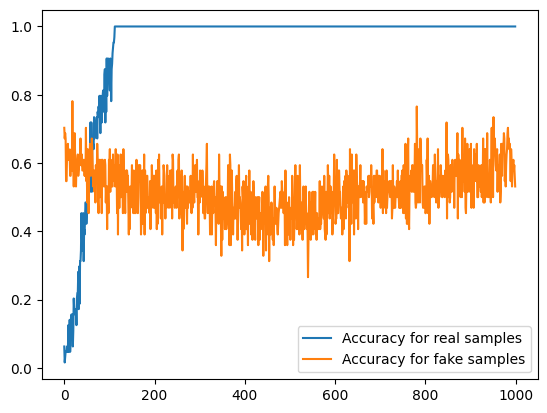

In [11]:
plt.plot(acc_real_logs, label="Accuracy for real samples")
plt.plot(acc_fake_logs, label="Accuracy for fake samples")
plt.legend(loc="best")

# Генератор
Перейдем к определению генератора. Генератор принимает на вход вектор размера latent_dim - т.е. размерность скрытого пространства, а
выдает вектор размерности наших данных - т.е. 2. В нашем случае мы будем использовать latent_dim=5 (выбрано произвольно). Т.е. задача
генератора превращать случайные векторы длины 5 в векторы длины 2.

In [12]:
def build_generator(latent_dim, n_outputs=2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(15, activation='relu', input_dim=latent_dim))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs))
    return model

# define the generator model
generator = build_generator(5)
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 15)                90        
                                                                 
 dense_7 (Dense)             (None, 10)                160       
                                                                 
 dense_8 (Dense)             (None, 2)                 22        
                                                                 
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________


In [13]:
def generate_latent_points(latent_dim, n):
    x_input = np.random.randn(n, latent_dim)
    return x_input

In [14]:
random_vectors = generate_latent_points(latent_dim=5, n=3)
print("Случайные векторы размера 5:", random_vectors)

Случайные векторы размера 5: [[ 0.1475922   0.38676898 -0.69721146  0.91301835 -0.61660663]
 [-2.11504904  0.06284693  0.42541746  0.04659447  3.68228602]
 [ 0.34551889  0.08910498  0.94001796 -1.33391806  1.64645858]]


In [15]:
generator(random_vectors).numpy() # генератор превратил из в векторы длины 2

array([[-0.01866209, -0.25586927],
       [-0.2629267 , -0.7874525 ],
       [-0.048096  , -0.714181  ]], dtype=float32)

In [16]:
def generate_fake_samples(generator, n):
    x_input = generate_latent_points(generator.input_shape[1], n)
    X = generator(x_input)
    return X

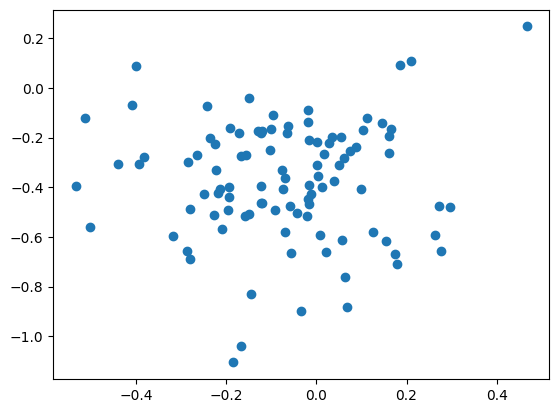

In [19]:
X = generate_fake_samples(generator, n=100)
plt.scatter(X[:, 0], X[:, 1])

# Лосс генератора
Лосс функция генератора принимает маленькие значения, если дискриминатор ошибается на примерах, которые сгенерировал генератор (т.е.
когда у него получается обмануть его). И наоборот - большие, если дискриминатор идеально справился со своей задачей.
На вход лосс функция принимает выходы дискриминатора на фейковых данных.

In [20]:
def generator_loss(discr_pred_fake_data):
    """
    discr_pred_fake_data -- предсказания дискриминатора на фейковых данных
    """
    labels = tf.ones_like(discr_pred_fake_data)
    # для генератора "хорошо"
    # когда фейковые данные дискриминатор назвал реальными
    return cross_entropy(labels, discr_pred_fake_data)

# Собираем вместе
Для начала реализуем как и выше train_step. В нем мы должны:
   1. Сэмплировать batch_size/2 точек из реального распределения(x_real)
   2. Сэмплировать batch_size/2 точек с помощью текущей версии генератора(x_fake)
   3. Сделать forward_pass дискриминатора на x_real и x_fake, получив discr_pred_real_data и discr_pred_fake_data.
   4. Посчитать лосс дискриминатора и генератора.
   5. Обновить параметры генератора и дискриминатора. Они оба должны теперь "научиться" на своих ошибках - дискриминатор должен различать данные еще лучше, а генератор должен генерировать более правдоподобные выборки.

In [40]:
def train_step(discriminator, generator, optimizer, batch_size=128):
    half_batch = int(batch_size / 2)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 1. Сэмплируем batch_size/2 точек из реального распределения
        X_real = generate_real_samples(n=half_batch)
        
        # генератор генерирует данные из латентных векторов, которые в свою очередь принадлежат простому распределению
        # и учится превращать их в распределение которое сможет обмануть дискриминатор
        # сначала генерируем латентные векторы --
        latent_z = np.random.rand(half_batch, generator.input_shape[1])
        # а затем превращаем их с помощью генератора в X_fake
        X_fake = generator(latent_z)
        
        # 3. Делаем forward_pass  дискриминатора на x_real и x_fake,
        # получив discr_pred_real_data и discr_pred_fake_data
        discr_pred_real_data = discriminator(X_real)
        discr_pred_fake_data = discriminator(X_fake)
        
        # 4. Посчитать лосс дискриминатора и генератора
        disc_loss = discriminator_loss(discr_pred_real_data, discr_pred_fake_data)
        gen_loss = generator_loss(discr_pred_fake_data)
        
    # считаем производные
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # 5. Обновляем параметры генератора и дискриминатора.
    optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return disc_loss.numpy(), gen_loss.numpy()         

In [41]:
def show_result(generator, title=""):
    X_fake = generate_fake_samples(generator=generator, n=100)
    X_real = generate_real_samples(n=100)
    plt.figure()
    plt.title(title)
    plt.scatter(X_real[:, 0], X_real[:, 1], label="real samples")
    plt.scatter(X_fake[:, 0], X_fake[:, 1], label="generated samples")
    plt.legend(loc='best')

In [42]:
def train_gan(discriminator, generator, optimizer, n_epochs=10000, n_batch=128, show_every=1000):
    losses_hist_disc = []
    losses_hist_gen = []
    for i in tqdm(range(n_epochs)):
        if i % show_every == 0:
            show_result(generator=generator, title=f"Epoch {i}")
        
        disc_loss, gen_loss = train_step(discriminator, generator, optimizer, n_batch)
        losses_hist_disc.append(disc_loss)
        losses_hist_gen.append(gen_loss)
    return losses_hist_disc, losses_hist_gen

# Переходим к обучению

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:41<00:00, 45.23it/s]


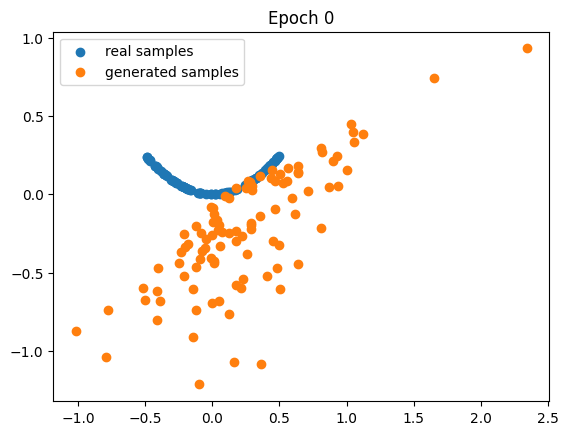

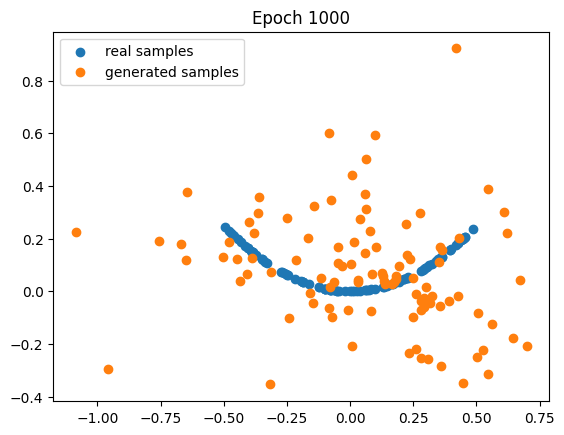

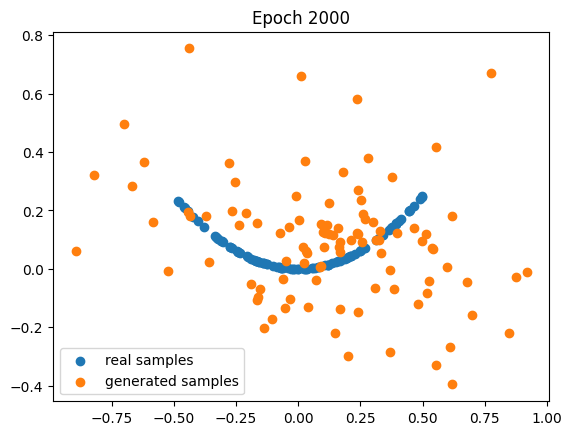

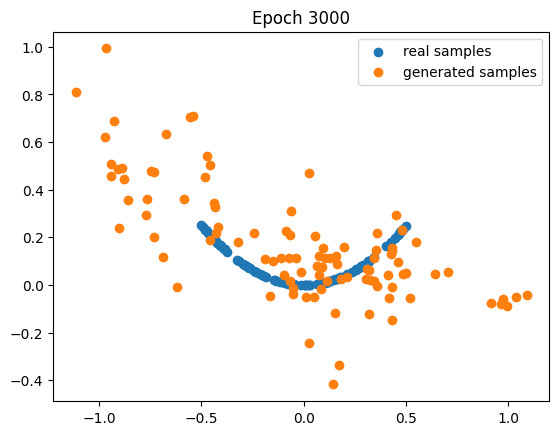

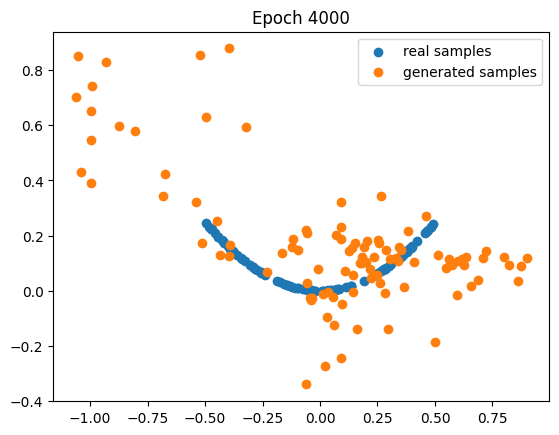

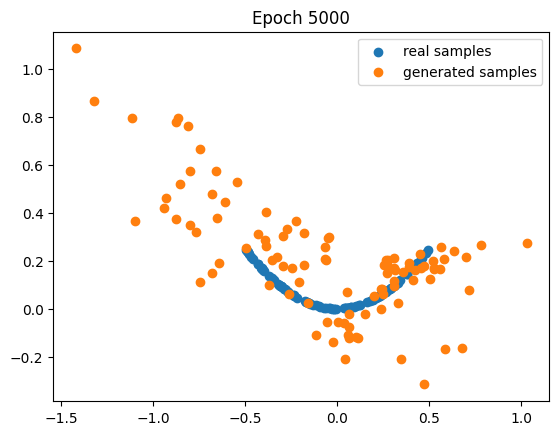

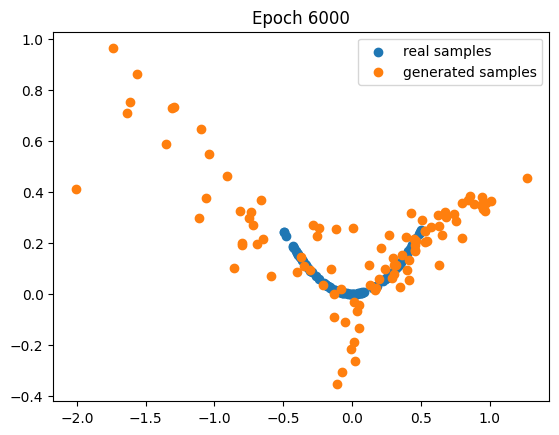

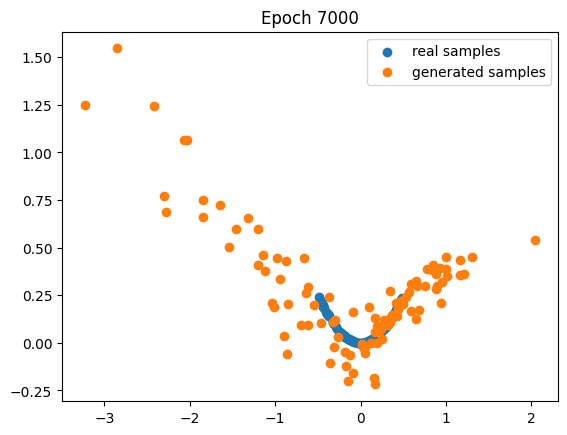

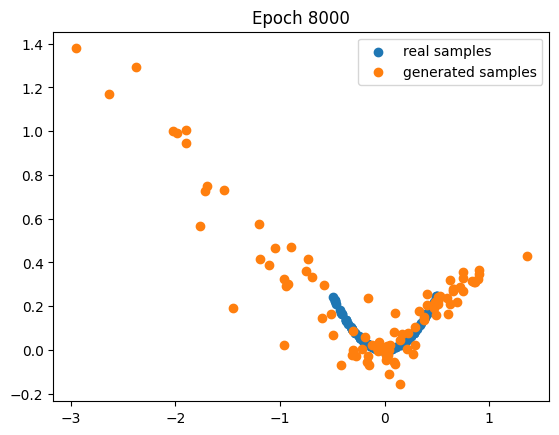

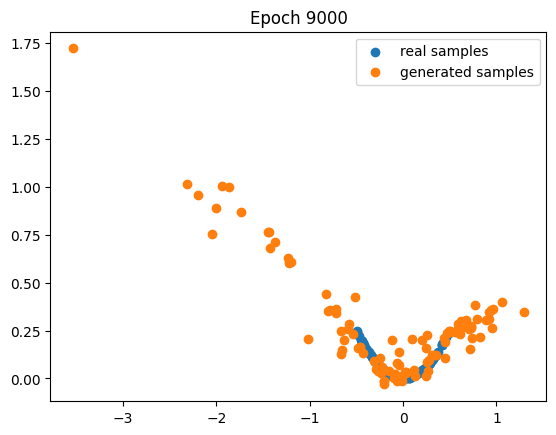

In [43]:
generator = build_generator(latent_dim=5, n_outputs=2)
discriminator = build_discriminator(n_inputs=2)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, beta_1=.5)

losses_hist_disc, losses_hist_gen = train_gan(discriminator, generator, optimizer, n_epochs=10000, show_every=1000)

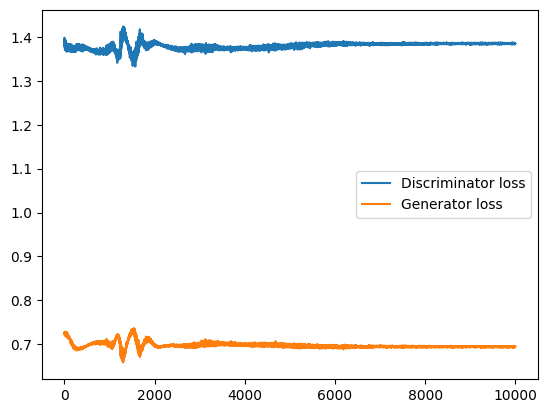

In [44]:
plt.plot(losses_hist_disc, label="Discriminator loss")
plt.plot(losses_hist_gen, label="Generator loss")
plt.legend(loc='best')

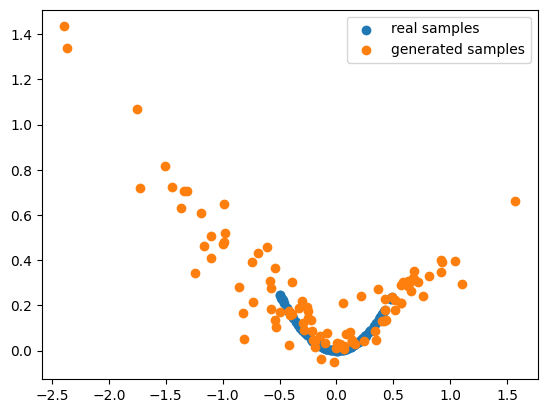

In [46]:
show_result(generator=generator)